# Data description

# Cardiovascular Disease Detection (EDA, Logistic Regression, Decision Tree, Random Forest,KNN)

In [1]:
# Importing essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline

#EDA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#importing classification models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (
    zero_one_loss, 
    accuracy_score, 
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report,
    precision_score,
    recall_score
)
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 9999


# Download and Explore the Data

In [2]:
# Loading the dataframe
disease_df = pd.read_csv(r"C:\Users\admin\Downloads/cardivascular dataset.csv",sep=';')


In [3]:
disease_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# Size of the dataset
disease_df.shape

(70000, 13)

In [5]:
disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
disease_df.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

In [7]:
disease_df.drop('id', inplace=True, axis=1)          #droping ID column(unique values)

In [8]:
disease_df.drop_duplicates(inplace=True)             #dropping dublicates values

In [9]:
disease_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
disease_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,69976.0,19468.950126,2467.374620,10798.0,17664.0,19703.0,21327.0,23713.0
gender,69976.0,1.349648,0.476862,1.0,1.0,1.0,2.0,2.0
height,69976.0,164.359152,8.211218,55.0,159.0,165.0,170.0,250.0
weight,69976.0,74.208519,14.397211,10.0,65.0,72.0,82.0,200.0
ap_hi,69976.0,128.820453,154.037729,-150.0,120.0,120.0,140.0,16020.0
ap_lo,69976.0,96.636261,188.504581,-70.0,80.0,80.0,90.0,11000.0
cholesterol,69976.0,1.366997,0.680333,1.0,1.0,1.0,2.0,3.0
gluc,69976.0,1.226535,0.572353,1.0,1.0,1.0,1.0,3.0
smoke,69976.0,0.088159,0.283528,0.0,0.0,0.0,0.0,1.0
alco,69976.0,0.053790,0.225604,0.0,0.0,0.0,0.0,1.0


Age is given in number of days, we need ot convert it into years.

In [11]:
#Converting age from days to years
disease_df['age'] = (disease_df['age'] / 365).round().astype('int64')

In [12]:
#ap_lo (diastolic bp) cannot be higher than ap_hi (systolic bp)
disease_df =disease_df.drop(disease_df[disease_df['ap_lo'] > disease_df['ap_hi']].index)

In [13]:
#create a body mass index 'bmi' feature from weight and height columns
disease_df["bmi"] = disease_df["weight"] / (disease_df["height"]/100)**2

In [14]:
disease_df.shape

(68742, 13)

In [15]:
disease_df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
bmi            0
dtype: int64

In [16]:
columns = ['age', 'height', 'weight', 'ap_lo', 'ap_hi', 'bmi']
for col in columns:
    column = disease_df[col]
    count = (column < 0).sum()
    print(col, ': ', count)

age :  0
height :  0
weight :  0
ap_lo :  1
ap_hi :  0
bmi :  0


In [17]:
#There is one negative values in ap_lo, diastolic bp cannot be negative. Eliminating this value
disease_df = disease_df.drop(disease_df[disease_df['ap_lo'] < 0].index)

In [18]:
disease_df.shape

(68741, 13)

In [19]:
#Systolic bp cannot be lower than 70 and higher than 200, diastolic bp cannot be less than 40 and more than 130.
#We remove the values which do not pass this criteria.

disease_df.drop(disease_df[(disease_df.ap_hi < 70) | (disease_df.ap_hi > 200)].index, inplace = True)
disease_df.drop(disease_df[(disease_df.ap_lo < 40) | (disease_df.ap_lo > 130)].index, inplace = True)

In [20]:
disease_df.shape

(68582, 13)

In [21]:
disease_df['ap_hi'].corr(disease_df['ap_lo'])

0.731224795005918

# Exploratory Data Analysis (EDA)

In [22]:
df = disease_df.copy(deep = True)

df['gender'].replace({1: 'woman', 2: 'man'}, inplace = True)
df['cholesterol'].replace({1: 'normal', 2: 'above normal', 3: 'well above normal'}, inplace = True)
df['gluc'].replace({1: 'normal', 2: 'above normal', 3: 'well above normal'}, inplace = True)
df['smoke'].replace({0: 'No', 1: 'Yes'}, inplace = True)
df['alco'].replace({0: 'No', 1: 'Yes'}, inplace = True)
df['active'].replace({0: 'No', 1: 'Yes'}, inplace = True)
df['cardio'].replace({0: 'No', 1: 'Yes'}, inplace = True)

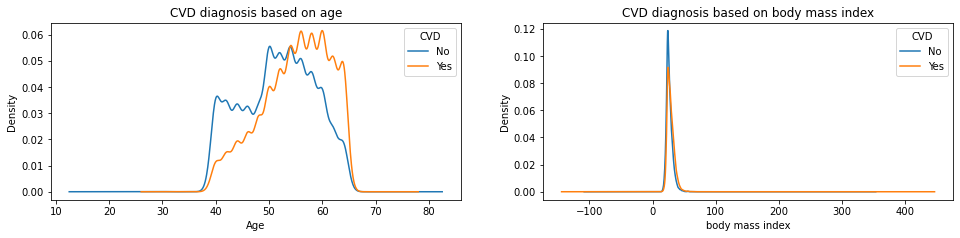

In [23]:
plt.figure(figsize =(25,15))
ax = plt.subplot(4,3, 1)
ax = df.groupby('cardio')['age'].plot(kind='kde', legend=True)
plt.title('CVD diagnosis based on age')
plt.xlabel('Age')
plt.legend(title="CVD")

ax = plt.subplot(4,3, 2)
ax = df.groupby('cardio')['bmi'].plot(kind='kde', legend=True)
plt.title('CVD diagnosis based on body mass index')
plt.xlabel('body mass index')
plt.legend(title="CVD")

Text(0.5, 1.0, 'cardiovascluar disease presence with age')

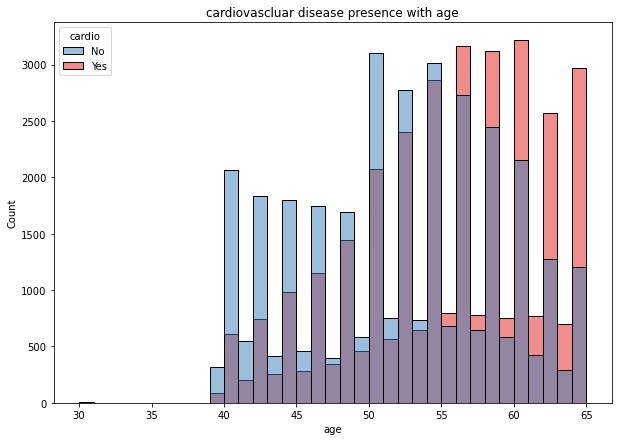

In [24]:
palette = {'No': '#377EB8', 'Yes': '#E41A1C'}
plt.figure(figsize=(10,7))
sns.histplot(data = df, x = 'age', hue = 'cardio', binwidth = 1, palette = palette, stat = 'count', alpha = 0.5)
plt.title("cardiovascluar disease presence with age")

Text(0.5, 1.0, 'cardiovascluar disease presence with age')

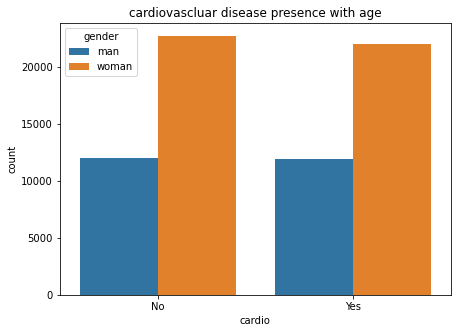

In [25]:
plt.figure(figsize=(7,5))
sns.countplot(data = df, x = 'cardio', hue = 'gender')
plt.title("cardiovascluar disease presence with age")

From the above graphs,

1.The people who are much older have more chances of having cardio vascular disease. people in the age range 55 to 65.
2.From age 40 to 50, it is less likely to have CVD.
3.The dataset reflects "woman" in about 65% of the cases, and "men" in the remaining 35%. However, the proportions of those with disease and those without it are roughly identical in both groups.

In [26]:
mean_age = disease_df['age'].mean()
print('Average age:', mean_age)

cardio_count = disease_df[(disease_df['age'] > mean_age) | (disease_df['age'] == mean_age)].cardio.value_counts()

print('\nIf your age is', mean_age, 'or above', mean_age)
print(cardio_count / cardio_count.sum())

Average age: 53.32575602927882

If your age is 53.32575602927882 or above 53.32575602927882
1    0.584169
0    0.415831
Name: cardio, dtype: float64


<Figure size 720x360 with 0 Axes>

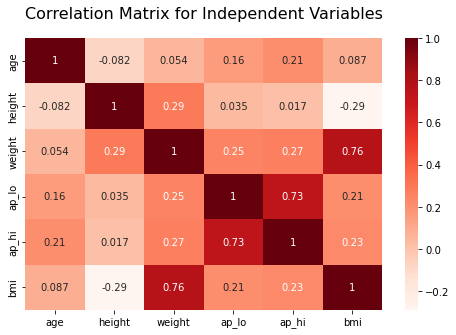

In [27]:
# heatmap for correlation
plt.figure(figsize=(10,5))
# heatmap for correlation
plt.figure(figsize = (8, 5))
plt.title('Correlation Matrix for Independent Variables', fontsize = 16, y = 1.05)

sns.heatmap(df[columns].corr(), annot = True, cmap = 'Reds');

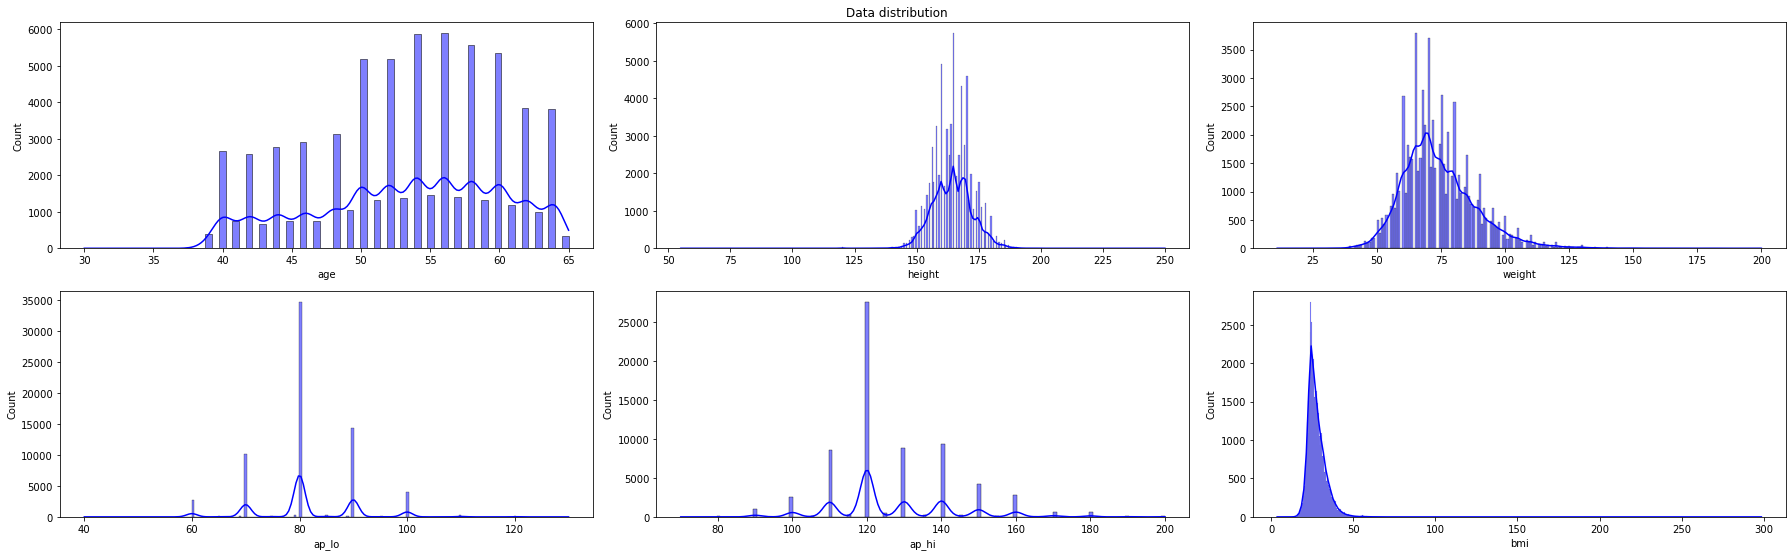

In [28]:
plt.figure(figsize=(25, 15))
for i, col in enumerate(columns):
#     print(i, col)
    ax = plt.subplot(4,3, i+1)
    sns.histplot(data=df, x=col, ax=ax,color='blue',kde=True)
    plt.suptitle('Data distribution')
    plt.tight_layout()

<AxesSubplot:>

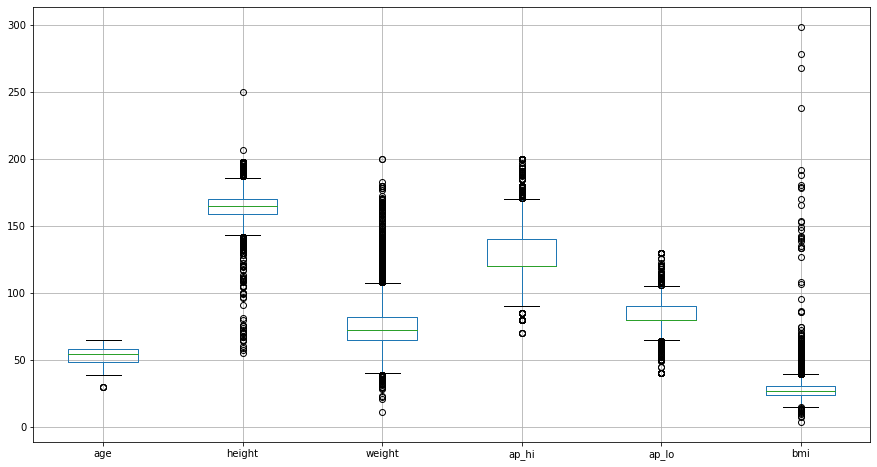

In [29]:
fig=plt.figure(figsize=(15,8))
df.boxplot()

In [30]:
df.shape

(68582, 13)

Compared to the shape of the dataset, the outliers detected above can be removed instead of imputing them with any values such as mean, 5th and 95th percentile values and so on.

In [31]:
# Checking outliers - detecting and handling outliers only for the continuous features
for col in columns:
    q1 = disease_df[col].quantile(0.25)
    q3 = disease_df[col].quantile(0.75)
    IQR = q3-q1
    min_Value = q1-1.5*IQR
    max_Value = q3+1.5*IQR

    outliers = []
    for i in disease_df[col]:
        #print(i)
        if i< min_Value or i>max_Value:
            outliers.append(i)
    print(f"Outliers in {col}:",len(outliers))
    
    df_out = disease_df.loc[(disease_df[col] > min_Value) & (disease_df[col] < max_Value)]


Outliers in age: 4
Outliers in height: 505
Outliers in weight: 1738
Outliers in ap_lo: 3445
Outliers in ap_hi: 946
Outliers in bmi: 2017


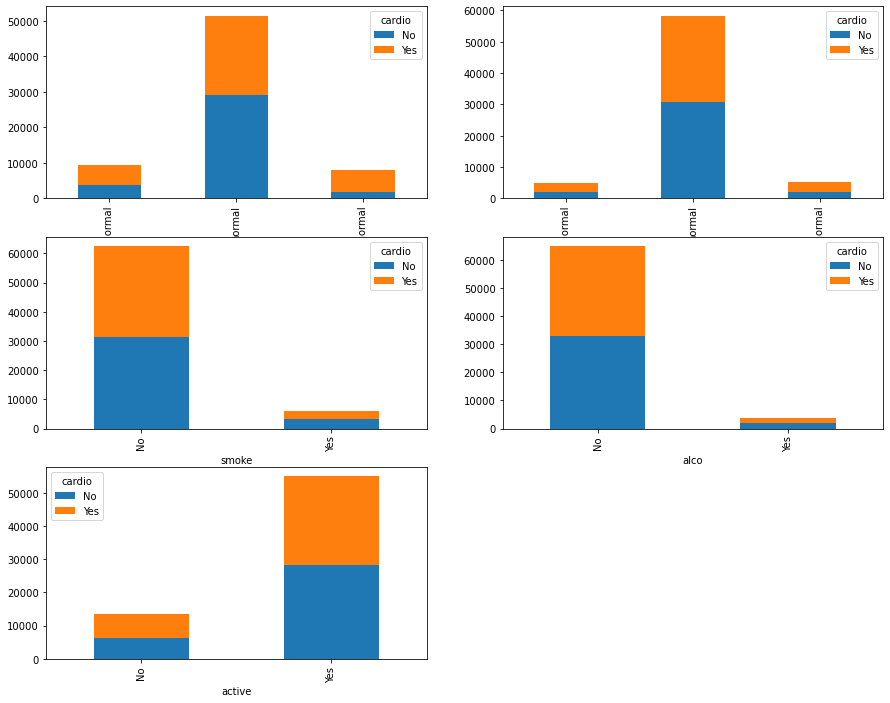

In [32]:
plt.figure(figsize=(15, 12))
category = ["cholesterol", "gluc", "smoke", "alco", "active"]
for i, col in enumerate(category):
    ax = plt.subplot(3, 2, i + 1)
    x = pd.crosstab(df[col], df["cardio"])
    x.plot(kind="bar", stacked=True, ax=ax)
plt.show()

In [33]:
df_out.shape

(66565, 13)

In [34]:
df_out.describe().T

,count,mean,std,min,25%,50%,75%,max
age,66565.0,53.298655,6.774862,30.000000,48.00000,54.000000,58.0000,65.000000
gender,66565.0,1.354916,0.478492,1.000000,1.00000,1.000000,2.0000,2.000000
height,66565.0,164.577375,7.801307,120.000000,159.00000,165.000000,170.0000,207.000000
weight,66565.0,73.032437,12.711089,28.000000,64.00000,71.000000,80.0000,135.000000
ap_hi,66565.0,126.283933,16.311126,70.000000,120.00000,120.000000,140.0000,200.000000
ap_lo,66565.0,81.112612,9.266658,40.000000,80.00000,80.000000,90.0000,130.000000
cholesterol,66565.0,1.356358,0.672342,1.000000,1.00000,1.000000,1.0000,3.000000
gluc,66565.0,1.220191,0.566020,1.000000,1.00000,1.000000,1.0000,3.000000
smoke,66565.0,0.089011,0.284761,0.000000,0.00000,0.000000,0.0000,1.000000
alco,66565.0,0.053286,0.224605,0.000000,0.00000,0.000000,0.0000,1.000000


In [35]:
df_out['cardio'].value_counts()

0    34037
1    32528
Name: cardio, dtype: int64

# Seprate dependent and independent columns¶

In [36]:
df_out.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [37]:
X = df_out.loc[:, df.columns != 'cardio']
y = df_out[['cardio']]

In [38]:
X.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,34.927679
2,52,1,165,64.0,130,70,3,1,0,0,0,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,28.710479
4,48,1,156,56.0,100,60,1,1,0,0,0,23.011177


Since out data does not follow gaussian distribution (i.e. it is not normal) we apply normalization to our data which adjusts the values of our numeric data to common scale without altering the range of the data. We also have removed outliers as well.

In [39]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(X)

x= norm.transform(X)

# Preparing the Data for the Model

In [40]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

In [41]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((53252, 12), (13313, 12), (53252, 1), (13313, 1))

# logistic regression

In [42]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()

In [43]:
lg.fit(x_train,y_train)

LogisticRegression()

In [44]:
lg_p=lg.predict(x_test)
lg_p

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [45]:
lg_prob=lg.predict_proba(x_test)
#lg_prob

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
lg_m=confusion_matrix(lg_p,y_test)
lg_m

array([[5304, 2174],
       [1537, 4298]], dtype=int64)

In [48]:
lg_ac=lg_m.diagonal().sum()/lg_m.sum()*100
lg_ac

72.1249906106813

In [49]:
lg_pr=precision_score(lg_p,y_test)
lg_pr

0.6640914709517923

In [50]:
lg_re=recall_score(lg_p,y_test)
lg_re

0.7365895458440446

In [51]:
lg_f1=f1_score(lg_p,y_test)
lg_f1

0.6984642886162348

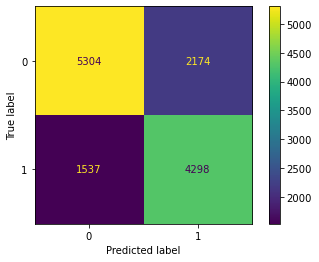

In [52]:
labels = [0,1]
cm = confusion_matrix(y_test, lg_p)
disp = ConfusionMatrixDisplay(confusion_matrix=lg_m, display_labels=labels)
disp.plot();

In [53]:
from sklearn.metrics import classification_report

In [54]:
print(classification_report(lg_p,y_test))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      7478
           1       0.66      0.74      0.70      5835

    accuracy                           0.72     13313
   macro avg       0.72      0.72      0.72     13313
weighted avg       0.73      0.72      0.72     13313



# decision tree

In [55]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

In [56]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [57]:
dt_p=dt.predict(x_test)

In [58]:
dt_cf=confusion_matrix(dt_p,y_test)
dt_cf

array([[4518, 2502],
       [2323, 3970]], dtype=int64)

In [59]:
dt_ac=dt_cf.diagonal().sum()/dt_cf.sum()*100
dt_ac

63.757229775407495

In [60]:
dt_pr=precision_score(dt_p,y_test)
dt_pr

0.6134116192830655

In [61]:
dt_re=recall_score(dt_p,y_test)
dt_re

0.630859685364691

In [62]:
dt_f1=f1_score(dt_p,y_test)
dt_f1

0.6220133176654916

In [63]:
dt.feature_importances_

array([0.13837679, 0.02699191, 0.11442557, 0.11043938, 0.24537508,
       0.04839329, 0.03882587, 0.02537723, 0.01176871, 0.00952959,
       0.01973557, 0.210761  ])

In [64]:
dt_df=pd.DataFrame({"Importance":list(dt.feature_importances_),"columns":list(X)})
dt_df

,Importance,columns
0,0.138377,age
1,0.026992,gender
2,0.114426,height
3,0.110439,weight
4,0.245375,ap_hi
5,0.048393,ap_lo
6,0.038826,cholesterol
7,0.025377,gluc
8,0.011769,smoke
9,0.009530,alco


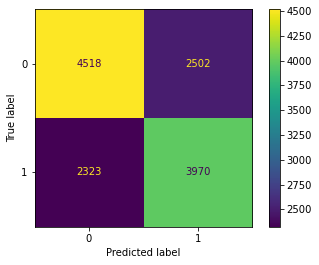

In [65]:
labels = [0,1]
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cf, display_labels=labels)
disp.plot();

In [66]:
 print(classification_report(dt_p,y_test))


              precision    recall  f1-score   support

           0       0.66      0.64      0.65      7020
           1       0.61      0.63      0.62      6293

    accuracy                           0.64     13313
   macro avg       0.64      0.64      0.64     13313
weighted avg       0.64      0.64      0.64     13313



In [67]:
path = dt.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

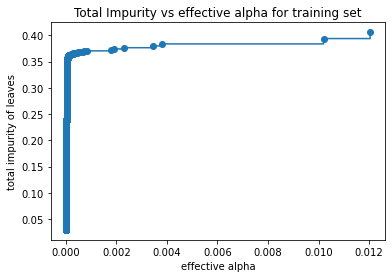

In [68]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# random forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()

In [70]:
rf = RandomForestClassifier()

In [71]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [72]:
rf_p=rf.predict(x_test)

In [73]:
cf=confusion_matrix(rf_p,y_test)
cf

array([[4942, 1992],
       [1899, 4480]], dtype=int64)

In [74]:
rf_ac=cf.diagonal().sum()/cf.sum()*100
rf_ac

70.77292871629236

In [75]:
rf_pr=precision_score(rf_p,y_test)
rf_pr

0.69221260815822

In [76]:
rf_re=recall_score(rf_p,y_test)
rf_re

0.7023044364320427

In [77]:
rf_f1=f1_score(rf_p,y_test)
rf_f1

0.6972220060695666

In [78]:
print(classification_report(rf_p,y_test))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      6934
           1       0.69      0.70      0.70      6379

    accuracy                           0.71     13313
   macro avg       0.71      0.71      0.71     13313
weighted avg       0.71      0.71      0.71     13313



In [79]:
#gridsearch to find best parameters for random forest classifier
params = {'criterion' : ['gini', "entropy", "log_loss"], 
          'max_depth' : range(2,11,1),
         'n_estimators' : range(2,11,1),
         'n_jobs': [2,3,4,5]}

grid = GridSearchCV(RandomForestClassifier(), params, refit = True, verbose = 3,n_jobs=-1, scoring='accuracy', cv=5) 
   
# fitting the model for grid search 
grid.fit(x_train, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(x_test) 

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 10, 'n_jobs': 2}


Accuracy of the Random Forest model: 72.84%

f1 score of the Random Forest model: 72.98%

Cross validation accuracy of the Random Forest model: 73.07%

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75      7635
           1       0.66      0.75      0.70      5678

    accuracy                           0.73     13313
   macro avg       0.73      0.73      0.73     13313
weighted avg       0.74      0.73      0.73     13313



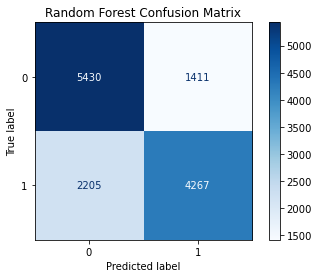

In [80]:
rf_model = RandomForestClassifier(criterion='gini', max_depth=9, n_estimators=8, n_jobs=2)

rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

accuracy = (accuracy_score(y_test,y_pred))*100
f1score = metrics.f1_score(y_pred,y_test,average='weighted')
precision=precision_score(y_pred,y_test)
recall=recall_score(y_pred,y_test)

kfold = KFold(n_splits=5)
cv = cross_val_score(rf_model,x_train,y_train,cv=kfold)

report = classification_report(y_pred,y_test, zero_division=1)

print(f"Accuracy of the Random Forest model: {round(accuracy, 2)}%\n")
print(f"f1 score of the Random Forest model: {round(f1score*100, 2)}%\n")
print(f"Cross validation accuracy of the Random Forest model: {round(np.mean(cv)*100, 2)}%\n")
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.grid(visible=False)
plt.show()

# KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=24)

In [82]:
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=24)

In [83]:
k_p=knn.predict(x_test)
k_p

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [84]:
ck=confusion_matrix(k_p,y_test)
ck

array([[5356, 2332],
       [1485, 4140]], dtype=int64)

In [85]:
k_ac=ck.diagonal().sum()/ck.sum()*100
k_ac

71.32877638398558

In [86]:
knn_pr=precision_score(k_p,y_test)
knn_pr

0.6396786155747837

In [87]:
knn_re=recall_score(k_p,y_test)
knn_re

0.736

In [88]:
knn_f1=f1_score(k_p,y_test)
knn_f1

0.6844672232784987

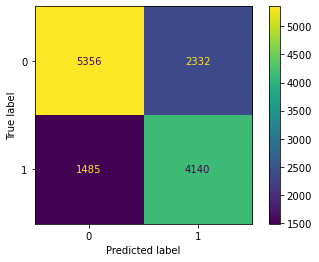

In [89]:
labels = [0,1]
disp = ConfusionMatrixDisplay(confusion_matrix=ck, display_labels=labels)
disp.plot();

In [90]:
print(classification_report(k_p,y_test))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      7688
           1       0.64      0.74      0.68      5625

    accuracy                           0.71     13313
   macro avg       0.71      0.72      0.71     13313
weighted avg       0.72      0.71      0.71     13313



In [91]:
list1=["LOGISTIC REGRESSION","DECISION TREE","RANDOM FOREST","KNN"]
list2=[lg_ac,dt_ac,accuracy,k_ac]
list3=[lg_pr,dt_pr,precision,knn_pr]
list4=[lg_re,dt_re,recall,knn_re]
list5=[lg_f1,dt_f1,f1score,knn_f1]


In [92]:
df1=pd.DataFrame({"Model Name":list1,"Accuracy":list2,"Precision":list3,"Recall":list4,"F1_score":list5})
df1

,Model Name,Accuracy,Precision,Recall,F1_score
0,LOGISTIC REGRESSION,72.124991,0.664091,0.736590,0.698464
1,DECISION TREE,63.757230,0.613412,0.630860,0.622013
2,RANDOM FOREST,72.838579,0.659302,0.751497,0.729812
3,KNN,71.328776,0.639679,0.736000,0.684467


# Prediction

In [93]:
test = [[35,1,168,62,110,70,1,0,1,0,1, 30.0]]
test = norm.transform(test)

In [94]:
pred = rf.predict(test)

In [95]:
if pred:
    print("Cardiovascular Disease Detected!")
else:
    print("NO! Cardiovascular Disease" )

NO! Cardiovascular Disease
